### <div class="alert-info"> 0. Librerías

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import re
from typing import Dict, Hashable
import prince
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns


### <div class="alert-info"> 1. Introducción al análisis - Fuentes de Información

Como parte del análisis de perfilamiento de individuos, se ha recibido la siguiente información de CNC:
- Resultados de la encuesta de campo de apropiación digital 2012 - CNC (Archivo xlsx)
- Resultados de la encuesta de campo de apropiación digital 2013 - CNC (Archivo xlsx)
- Resultados de la encuesta de campo de apropiación digital 2016 - CNC (Archivo xlsx)
- Resultados de la encuesta de campo de apropiación digital 2018 - CNC (Archivo xlsx)
- Resultados de la encuesta de campo de apropiación digital 2023 - CNC (Archivo xlsx)

De otro lado, también se tiene data de fuente externa que se cita a continuación:
- Resultados de Prueba Saber 11 (2010 a 20224) - Consulta de datos abiertos accesible vía API / Descarga de archivo CSV.
- Encuesta Nacional de Hogares DANE (2024) - Descarga de archivo CSV.

En este punto siendo que lo que se busca es apoyar al CNC a segmentar de forma idónea a los individuos de acuerdo a sus características así como del nivel de apropiación digital en sus diversas dimensiones (uso, frecuencia, accesibilidad, entre otras) se vio por conveniente solo usar:
- Resultados de la encuesta de campo de apropiación digital 2023 - CNC (Archivo xlsx)
Cabe precisar que, posteriormente se podrá evaluar la pertinencia de agregar otras fuentes de información al análisis, en tanto tenga el mismo nivel de granularidad.

### <div class="alert-info"> 2. Carga de datos

In [2]:
df_encuesta = pd.read_excel('datos.xlsx')
df_encuesta

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,...,BONO,SUP_2,SUP_1,LATITUD_FINAL,LONGITUD_FINAL,VERIFICA2,FOTOGRAFIA,FACTOR,indicador,nivel_piramide
0,2023,CC913901_AD_23_HOGAR,27848,1877,2023-04-04,14:47:01,2023-04-04,16:14:40,5257,NaN,...,1.0,NaN,2,7.113764,73.136595,1.0,NaN,3631.25000,0.076923,1
1,2023,CC913901_AD_23_HOGAR,16506,1885,2023-04-04,15:10:56,2023-04-04,16:31:17,4821,NaN,...,1.0,NaN,2,7.892407,72.513830,1.0,NaN,4035.33325,0.153846,1
2,2023,CC913901_AD_23_HOGAR,8681,1889,2023-04-04,15:16:08,2023-04-04,16:02:38,2758,NaN,...,1.0,NaN,2,7.892383,72.513792,1.0,NaN,3045.25000,0.000000,0
3,2023,CC913901_AD_23_HOGAR,8910,1898,2023-04-04,15:54:46,2023-04-04,17:03:58,4150,NaN,...,1.0,NaN,2,7.899648,72.535536,1.0,NaN,3478.57690,0.000000,0
4,2023,CC913901_AD_23_HOGAR,5739,1901,2023-04-04,15:59:03,2023-04-04,17:14:08,4504,NaN,...,1.0,NaN,1,7.897977,72.535518,1.0,NaN,5607.12500,0.571429,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,2023,CC913901_AD_23_HOGAR,25547,8703,2023-05-17,15:24:39,2023-05-17,17:28:02,6165,NaN,...,NaN,NaN,2,4.843900,74.066290,1.0,NaN,15206.21777,0.230769,2
4175,2023,CC913901_AD_23_HOGAR,847,8723,2023-05-18,10:23:46,2023-05-18,11:02:34,2270,NaN,...,1.0,NaN,2,4.854580,74.055531,1.0,NaN,15202.72266,0.153846,1
4176,2023,CC913901_AD_23_HOGAR,1459,8726,2023-05-18,10:12:49,2023-05-18,11:41:14,4967,NaN,...,1.0,NaN,2,4.857498,74.055302,1.0,NaN,15206.21777,0.615385,3
4177,2023,CC913901_AD_23_HOGAR,2108,8728,2023-05-18,11:11:37,2023-05-18,12:00:29,2931,NaN,...,1.0,NaN,2,4.854772,74.054638,1.0,NaN,20639.65039,0.230769,1


### Análisis 

Se observa que los resultados provienen de una encuesta aplicada a 4,179 hogares, generando un total de 1,173 columnas que incluyen las respuestas obtenidas y otros datos asociados. Durante esta primera evaluación, identificamos que la estructura del conjunto de datos refleja cómo las respuestas de varios individuos por hogar se expanden en múltiples columnas, sumándose también las opciones de respuesta para cada alternativa dada, lo que incrementa aún más el número de columnas.

Por lo tanto, consideramos como primer paso realizar un análisis detallado de las variables descritas en la encuesta (PDF) para comprender su contexto y significado. A partir de este entendimiento, se procederá a una selección inicial de variables relevantes, que serán evaluadas en términos de calidad de datos considerando dimensiones clave como totalidad, consistencia, claridad, formato y su concordancia con el problema de negocio planteado.

### <div class="alert-info"> 3. Calidad y limpieza de datos

#### 3.1. Selección inicial de variables

In [3]:
df_encuesta_respaldo = df_encuesta.copy()

In [4]:
#Eliminamos variables que en primera instancia identificamos que no son importantes para el análisis

#Todos los registros tienen un mismo valor
# CONTACTO, AUX99, AUX99_1, IDEND, TIPO_ENCUESTA, TIPO, ESTADO, ESTUDIO, ID, ID_CONTACTO, IDIOMA, TIPO_ENCUESTA

# No necesitamos los datos de contacto
# TELEFONO, EMAIL, DIRECCION_FILTRO, 'CEDULA','CELULAR'

# No requerimos los ids de identificacion, ni metadata de la encuesta
# IDGUID, IDGUIDCONTACTO, IDGUIDREC, IDAPK,
# IDDEVICE, IDBROWSER,  IDIP, IDMODE, IDMODEL, IDSCREEN, 
# IDSO, IDPPI, IDVERSO, IDVERSION, N_ENCUESTA, ID_MANZANA, ID_MANZ_AUX,
# VEREDA, PFECACT, PERSONA_SELECCIONADA,NOMBRE_SEL,GENERO_SEL,EDAD,
# CONTINUAR,REDAD,AUTORIZA_INI_MAYOR,CONTINUAR_1,AUTORIZA_INI_MENOR,NOM_ADULTO,
# RELACION_MENOR,PARTICIPA_MENOR,REEMPLAZO,P2E_REEMPLAZO,AUTORIZA_INI_MAYOR_1,CONTINUAR_1_1,
# AUTORIZA_INI_MENOR_1,NOM_ADULTO_1,RELACION_MENOR_1,PARTICIPA_MENOR_1, 'DANE', ENTREVISTADOR, IDCOORD,
# FECHAINI, HORAINI, FECHAFIN, HORAFIN, DURACION

# Información personal irrelevante
# MUNICIPIO_DEC, 'B4_4_1', 'B4_4_2', 'B4_4_3', 'GPSVAL', 'GPSALT', 'GPSLONG', 'GPSLAT', 'GPSPRECISION', 'IDVERBROWSER', 'IDUSUARIO', 'LONG_1', 'LAT_1': Variable duplicada de otra variable
# NOMBRE_n, PDIA_n, PMES_n, PFEC_n, B3_NOMBRES_n, SEXO_n, EDAD_n,
# 'NOM_ENTRE','TEL_ENTRE','CEL_ENTRE','DIR_ENTRE','BAR_ENTRE','ST_DEC','ESTRATO'

# Informacion muy especifica
#  'Unnamed:276','B4_3','B4_3_OTRO', 'B4_4_TOTAL', 'B4_5_1', 'B4_5_2', 'B4_5_3', 'B4_5_4', 'B4_5_5',
# 'B4_6_1','B4_6_2','B4_6_3','B4_6_51','B4_6_6','B4_6_7','B4_6_8',\n'B4_6_9','B4_6_10','B4_6_11','B4_6_12','B4_6_13','B4_6_14',\n'B4_6_15','B4_6_49','B4_6_16','B4_6_17','B4_6_18','B4_6_19',\n'B4_6_20','B4_6_21','B4_6_22','B4_6_23','B4_6_24','B4_6_25',\n'B4_6_26','B4_6_27','B4_6_29','B4_6_30','B4_6_32','B4_6_33',\n'B4_6_34','B4_6_35','B4_6_36','B4_6_37','B4_6_38','B4_6_39',\n'B4_6_40','B4_6_41','B4_6_42','B4_6_43','B4_6_44','B4_6_45',\n'B4_6_46','B4_6_47','B4_6_48','B4_6_50','B4_6_66','B4_6_52',\n'B4_6_53',
# 'B4_6_54','B4_6_55','B4_6_56','B4_6_57','B4_6_58','B4_6_59','B4_6_60','B4_6_61','B4_6_62','B4_6_64','B4_7', 'CB5_5', 'B5_5', 'B5_11','B5_11_OTRA',
# 'B6_1_OTRO', 'B6_4','B64_OTRO', 'B7_2', 'B7_3M', 'B7_4','B7_5M', 'B8_3_1','B8_3_2','B8_3_3','B8_3_4','B8_3_5','B8_3_6','B8_3_7','B8_3_8','B8_3_9','B8_3_10','B8_3_11','B8_3_12', 'B9_2',
# 'B9_5_1','B9_5_2','B9_5_3', 'B9_6','B9_6_OTRO', 'B10_2','B10_2B', 'B10_3H','B10_3M','B10_4','B10_5H','B10_5M', 
# 'B10_6_1','B10_6_2','B10_6_3','B10_6_4','B10_6_5','B10_6_6','B10_6_7','B10_6_8','B10_6_9','B10_6_10','B10_6_26','B10_6_19','B10_6_20','B10_6_21','B10_6_22','B10_6_23','B10_6_24','B10_6_25','B10_7_1','B10_7_2','B10_7_3','B10_7_4','B10_7_5','B10_7_6','B10_7_7','B10_7_8','B10_7_9','B10_7_10','B10_7_26','B10_7_19','B10_7_20','B10_7_21','B10_7_22','B10_7_23','B10_7_24','B10_7_25','B10_8_1','B10_8_2','B10_8_3','B10_8_4','B10_8_5','B10_8_6','B10_8_7','B10_8_8','B10_8_9','B10_8_10','B10_8_26','B10_8_19','B10_8_20','B10_8_21'
# 'B10_13_1','B10_13_2','B10_13_3','B10_13_4','B10_13_5','B10_13_6','B10_13_7','B10_13_8','B10_13_9','B10_13_10','B10_13_26','B10_13_19','B10_13_20','B10_13_21','B10_13_22','B10_13_23','B10_13_24', 'B10_13_25'
# 'B10_14_1','B1014_OT_1','B10_14_2','B1014_OT_2','B10_14_3','B1014_OT_3','B10_14_4','B1014_OT_4','B10_14_5','B1014_OT_5','B10_14_6','B1014_OT_6','B10_14_7','B1014_OT_7','B10_14_8','B1014_OT_8','B10_14_9','B1014_OT_9','B10_14_10','B1014_OT_10','B10_14_26','B1014_OT_26','B10_14_19','B1014_OT_19','B10_14_20','B1014_OT_20','B10_14_21','B1014_OT_21','B10_14_22','B1014_OT_22','B10_14_23','B1014_OT_23','B10_14_24','B1014_OT_24','B10_14_25','B1014_OT_25',
# 'B10_15_1','B10_15_2','B10_15_3','B10_15_4','B10_15_5','B10_15_6','B10_15_7','B10_15_8','B10_15_9','B10_15_10','B10_15_26','B10_15_19','B10_15_20','B10_15_21','B10_15_22','B10_15_23','B10_15_24','B10_15_25'
# 'B10_16_1','B10_16_2','B10_16_3','B10_16_4','B10_16_5','B10_16_6','B10_16_7','B10_16_8','B10_16_9','B10_16_10','B10_16_26','B10_16_19','B10_16_20','B10_16_21','B10_16_22','B10_16_23','B10_16_24','B10_16_25'
# 'CB10_17_1','B10_17_1','CB10_17_2','B10_17_2','CB10_17_3','B10_17_3','CB10_17_4','B10_17_4','CB10_17_5','B10_17_5','CB10_17_6','B10_17_6','CB10_17_7','B10_17_7','CB10_17_8','B10_17_8','CB10_17_9','B10_17_9','CB10_17_10','B10_17_10','CB10_17_26','B10_17_26','CB10_17_19','B10_17_19','CB10_17_20','B10_17_20','CB10_17_21','B10_17_21','CB10_17_22','B10_17_22','CB10_17_23','B10_17_23','CB10_17_24','B10_17_24','CB10_17_25','B10_17_25'
# 'B11_1_OTRO','B11_2_1','CB11_2_COOP_1','B11_2_COOP_1','B11_2_OTRO_1','B11_2_2','CB11_2_COOP_2','B11_2_COOP_2','B11_2_OTRO_2','B11_2_3','CB11_2_COOP_3','B11_2_COOP_3','B11_2_OTRO_3','B11_2_4','CB11_2_COOP_4','B11_2_COOP_4','B11_2_OTRO_4','B11_2_5','CB11_2_COOP_5','B11_2_COOP_5','B11_2_OTRO_5','B11_2_6','CB11_2_COOP_6','B11_2_COOP_6','B11_2_OTRO_6','B11_2_7','CB11_2_COOP_7','B11_2_COOP_7','B11_2_OTRO_7','B11_2_77','CB11_2_COOP_77','B11_2_COOP_77','B11_2_OTRO_77'
# 'B11_5_OTRO','B11_6','CB11_7_1','B11_7_1','CB11_7_2','B11_7_2','CB11_7_3','B11_7_3','CB11_7_4','B11_7_4','CB11_7_5','B11_7_5','CB11_7_6','B11_7_6','CB11_7_7','B11_7_7','CB11_7_8','B11_7_8','CB11_7_9','B11_7_9','CB11_7_10','B11_7_10','CB11_7_11','B11_7_11'
# 'B10_18','B10_19'
# 'B11_8','B11_8_OTRO','B11_9'
# 'CB11_10_1','B11_10_1','CB11_10_2','B11_10_2','CB11_10_3','B11_10_3','CB11_10_4','B11_10_4','CB11_10_5','B11_10_5','CB11_10_6','B11_10_6','CB11_10_7','B11_10_7','CB11_10_8','B11_10_8','CB11_10_9','B11_10_9','CB11_10_10','B11_10_10','CB11_10_11','B11_10_11'
# 'B11_12_OTRO', 'B11_11_OTRO'
# ,'B12_3_OTRO', 'B12_1_OTRO', 'B12_3A','B12_3_OTRO','TB12_3_1','TB12_3_2','TB12_3_3','TB12_3_4','TB12_3_5','TB12_3_6','TB12_3_7','TB12_3_8','TB12_3_9','TB12_3_10','TB12_3_11','TB12_3_12','TB12_3_13','TB12_3_14','TB12_3_15','TB12_3_16'
# 'B12_4_1','B12_4_2','B12_4_3','B12_4_4', 'B12_5_OTRO',
# 'B13_3L','CORREO',
# 'B14_1L', 'B14_3', 'B15_3L', 'B16_1_OTRO', 'B16_2'
# 'B16_3_1','B16_3_2','B16_3_3','B16_3_4','B16_3_5','B16_3_8','B16_3_10','B16_3_12','B16_3_15','B16_3_26','B16_3_27','B16_3_29','B16_3_30','B16_3_31','B16_3_33','B16_3_32','B16_3_77'
# 'B16_4_1','B16_4_2','B16_4_3','B16_4_4','B16_4_5'
# 'B16_5','B16_6','B16_6_OTRO'
# 'B17_1','B17_1_OTRO','B17_2','B17_2_OTRO','B17_3','B17_4','B17_5','B17_6','B17_7','B17_8','B17_9','B17_10','B17_11_1','B17_11_2','B17_11_3','B17_11_4','B17_11_5','B17_11_6','B17_11_7','B17_11_8','B17_11_9','B17_11_10','B17_11_11'
# 'B18_1','MAYOR_B18_1','B18_2','B18_3'
# 'B20_1','B20_2','B20_2_OTRO','B20_4_1','B20_4_2','B20_4_3','B20_5_1','B20_5_2','B20_5_3','B20_6_1','B20_6_2','B20_6_3','B20_6_4','B20_6_5','B20_6_6','B20_7_1','B20_7_2','B20_7_3','B20_7_4','B20_7_5','B20_8_1','B20_8_2','B20_8_3','B20_8_4','B20_8_5','B20_8_6','B20_8_7','B20_8_8','B20_8_9',
# 'B21_1_OTRO','B21_2','B21_2_OTRO'
# 'B22_1','B22_6','B22_7','B22_8','B22_9'
# 'B23_1','B23_1_OTRO','B23_2','B23_3','B23_3_OTRO','B23_5','B23_7_1','B23_7_2','B23_7_3','B23_7_77',
# 'B24_1','B24_1_OTRO','B24_2_2','CB24_3_1','B24_3_1','CB24_3_2','B24_3_2','B24_5','B24_6','B24_6_OTRO','B24_8','B24_9'
# 'B25_1','B25_3'
# 'B28_1','B28_1_OTRO','B28_4','B28_5','B28_5_OTRO','B28_6'
# 'B26_3_OTRO', 'B26_4','B26_4_OTRO','B26_5','B26_6_OTRO','B26_7','B26_8','CB26_9','B26_9','B26_10', 'B26_15','B26_15_OTRO','B26_16','B26_16_OTRO'
# 'REGIONAL','CODDANE','POINT_X','POINT_Y', 'SECTOR', 'SECCION', 'MANZANA', 'REGION_BASE', 'MUNICIPIO'

variables_eliminadas_poca_relevancia = ['ESTUDIO', 'ENTREVISTADOR', 'ID', 'FECHAINI', 'HORAINI', 'FECHAFIN', 'HORAFIN', 'DURACION', 'ID_CONTACTO',
                                        'EMAIL', 'TELEFONO', 'ESTADO', 'IDIOMA', 'IDCOORD', 'IDGUID', 'IDGUIDCONTACTO', 'IDGUIDREC', 'IDAPK', 
                                        'IDDEVICE', 'IDBROWSER', 'IDIP', 'IDMODE', 'IDMODEL', 'IDSCREEN', 'IDSO', 'IDPPI', 'IDVERSO', 'IDVERSION',
                                        'TIPO_ENCUESTA', 'TIPO', 'AUX99_1', 'IDEND', 'N_ENCUESTA', 'AUX99', 'ID_MANZANA', 'ID_MANZ_AUX',
                                        'FOTO', 'CONTACTO', 'MUNICIPIO_DEC', 'VEREDA', 'PFECACT', 
                                        'NOMBRE_1', 'PDIA_1','PMES_1','PFEC_1', 'NOMBRE_2', 'PDIA_2','PMES_2','PFEC_2', 
                                        'NOMBRE_3', 'PDIA_3','PMES_3','PFEC_3', 'NOMBRE_4', 'PDIA_4','PMES_4','PFEC_4', 
                                        'NOMBRE_5', 'PDIA_5','PMES_5','PFEC_5', 'NOMBRE_6', 'PDIA_6','PMES_6','PFEC_6', 
                                        'NOMBRE_7', 'PDIA_7','PMES_7','PFEC_7', 'NOMBRE_8', 'PDIA_8','PMES_8','PFEC_8',
                                        'NOMBRE_9', 'PDIA_9','PMES_9','PFEC_9', 'NOMBRE_10', 'PDIA_10','PMES_10','PFEC_10',
                                        'NOMBRE_11', 'PDIA_11','PMES_11','PFEC_11', 'NOMBRE_12', 'PDIA_12','PMES_12','PFEC_12', 
                                        'NOMBRE_13', 'PDIA_13','PMES_13','PFEC_13', 'NOMBRE_14', 'PDIA_14','PMES_14','PFEC_14', 
                                        'NOMBRE_15', 'PDIA_15','PMES_15','PFEC_15',
                                        'SEXO_1','EDAD_1','SEXO_2','EDAD_2','SEXO_3','EDAD_3','SEXO_4','EDAD_4',
                                        'SEXO_5','EDAD_5', 'SEXO_6','EDAD_6','SEXO_7','EDAD_7','SEXO_8','EDAD_8','SEXO_9','EDAD_9',
                                        'SEXO_10','EDAD_10','SEXO_11','EDAD_11','SEXO_12','EDAD_12','SEXO_13','EDAD_13','SEXO_14','EDAD_14','SEXO_15','EDAD_15',
                                        'DIRECCION_FILTRO', 'PERSONA_SELECCIONADA','NOMBRE_SEL','GENERO_SEL','EDAD','CONTINUAR','REDAD','AUTORIZA_INI_MAYOR','CONTINUAR_1','AUTORIZA_INI_MENOR','NOM_ADULTO','RELACION_MENOR','PARTICIPA_MENOR','REEMPLAZO','P2E_REEMPLAZO','AUTORIZA_INI_MAYOR_1','CONTINUAR_1_1','AUTORIZA_INI_MENOR_1','NOM_ADULTO_1','RELACION_MENOR_1','PARTICIPA_MENOR_1',
                                        'B3_NOMBRES_1','B3_NOMBRES_2','B3_NOMBRES_3','B3_NOMBRES_4','B3_NOMBRES_5','B3_NOMBRES_6','B3_NOMBRES_7','B3_NOMBRES_8','B3_NOMBRES_9','B3_NOMBRES_10','B3_NOMBRES_11','B3_NOMBRES_12','B3_NOMBRES_13','B3_NOMBRES_14','B3_NOMBRES_15',
                                        'NOM_ENTRE','TEL_ENTRE','CEL_ENTRE','DIR_ENTRE','BAR_ENTRE','ST_DEC','ESTRATO', 'Unnamed: 276','B4_3','B4_3_OTRO',
                                        'B4_4_1', 'B4_4_2', 'B4_4_3', 'B4_4_TOTAL', 'B4_5_1', 'B4_5_2', 'B4_5_3', 'B4_5_4', 'B4_5_5',
                                        'B4_6_1','B4_6_2','B4_6_3','B4_6_51','B4_6_6','B4_6_7','B4_6_8','B4_6_9','B4_6_10','B4_6_11','B4_6_12','B4_6_13','B4_6_14','B4_6_15','B4_6_49','B4_6_16','B4_6_17','B4_6_18','B4_6_19','B4_6_20','B4_6_21','B4_6_22','B4_6_23','B4_6_24','B4_6_25','B4_6_26','B4_6_27','B4_6_29','B4_6_30','B4_6_32','B4_6_33','B4_6_34','B4_6_35','B4_6_36','B4_6_37','B4_6_38','B4_6_39','B4_6_40','B4_6_41','B4_6_42','B4_6_43','B4_6_44','B4_6_45','B4_6_46','B4_6_47','B4_6_48','B4_6_50','B4_6_66','B4_6_52','B4_6_53', 'B4_6_54','B4_6_55','B4_6_56','B4_6_57','B4_6_58','B4_6_59','B4_6_60','B4_6_61','B4_6_62','B4_6_64','B4_7',
                                        'CB5_5', 'B5_5', 'B5_11','B5_11_OTRA', 'B6_4','B64_OTRO', 'B6_1_OTRO', 'B7_2', 'B7_3M', 'B7_4','B7_5M',
                                        'B8_3_1','B8_3_2','B8_3_3','B8_3_4','B8_3_5','B8_3_6','B8_3_7','B8_3_8','B8_3_9','B8_3_10','B8_3_11','B8_3_12', 'B9_2',
                                        'B9_5_1','B9_5_2','B9_5_3',
                                        'B9_6','B9_6_OTRO',
                                        'B10_2','B10_2B',
                                        'B10_3H','B10_3M','B10_4','B10_5H','B10_5M',
                                        'B10_6_1','B10_6_2','B10_6_3','B10_6_4','B10_6_5','B10_6_6','B10_6_7','B10_6_8','B10_6_9','B10_6_10','B10_6_26','B10_6_19','B10_6_20','B10_6_21','B10_6_22','B10_6_23','B10_6_24','B10_6_25','B10_7_1','B10_7_2','B10_7_3','B10_7_4','B10_7_5','B10_7_6','B10_7_7','B10_7_8','B10_7_9','B10_7_10','B10_7_26','B10_7_19','B10_7_20','B10_7_21','B10_7_22','B10_7_23','B10_7_24','B10_7_25','B10_8_1','B10_8_2','B10_8_3','B10_8_4','B10_8_5','B10_8_6','B10_8_7','B10_8_8','B10_8_9','B10_8_10','B10_8_26','B10_8_19','B10_8_20','B10_8_21', 'B10_8_22','B10_8_23','B10_8_24','B10_8_25','B10_9_1','B10_9L_1','B10_9_2','B10_9L_2','B10_9_3','B10_9L_3','B10_9_4','B10_9L_4','B10_9_5','B10_9L_5','B10_9_6','B10_9L_6','B10_9_7','B10_9L_7','B10_9_8','B10_9L_8','B10_9_9','B10_9L_9','B10_9_10','B10_9L_10','B10_9_26','B10_9L_26','B10_9_19','B10_9L_19','B10_9_20','B10_9L_20','B10_9_21','B10_9L_21','B10_9_22','B10_9L_22','B10_9_23','B10_9L_23','B10_9_24','B10_9L_24','B10_9_25','B10_9L_25','B10_10_1','B10_10_2','B10_10_3','B10_10_4','B10_10_5','B10_10_6','B10_10_7','B10_10_8','B10_10_9','B10_10_10', 'B10_10_26','B10_10_19','B10_10_20','B10_10_21','B10_10_22','B10_10_23','B10_10_24','B10_10_25',
                                        'B10_13_1','B10_13_2','B10_13_3','B10_13_4','B10_13_5','B10_13_6','B10_13_7','B10_13_8','B10_13_9','B10_13_10','B10_13_26','B10_13_19','B10_13_20','B10_13_21','B10_13_22','B10_13_23','B10_13_24', 'B10_13_25',
                                        'B10_14_1','B1014_OT_1','B10_14_2','B1014_OT_2','B10_14_3','B1014_OT_3','B10_14_4','B1014_OT_4','B10_14_5','B1014_OT_5','B10_14_6','B1014_OT_6','B10_14_7','B1014_OT_7','B10_14_8','B1014_OT_8','B10_14_9','B1014_OT_9','B10_14_10','B1014_OT_10','B10_14_26','B1014_OT_26','B10_14_19','B1014_OT_19','B10_14_20','B1014_OT_20','B10_14_21','B1014_OT_21','B10_14_22','B1014_OT_22','B10_14_23','B1014_OT_23','B10_14_24','B1014_OT_24','B10_14_25','B1014_OT_25',
                                        'B10_15_1','B10_15_2','B10_15_3','B10_15_4','B10_15_5','B10_15_6','B10_15_7','B10_15_8','B10_15_9','B10_15_10','B10_15_26','B10_15_19','B10_15_20','B10_15_21','B10_15_22','B10_15_23','B10_15_24','B10_15_25',
                                        'B10_16_1','B10_16_2','B10_16_3','B10_16_4','B10_16_5','B10_16_6','B10_16_7','B10_16_8','B10_16_9','B10_16_10','B10_16_26','B10_16_19','B10_16_20','B10_16_21','B10_16_22','B10_16_23','B10_16_24','B10_16_25',
                                        'CB10_17_1','B10_17_1','CB10_17_2','B10_17_2','CB10_17_3','B10_17_3','CB10_17_4','B10_17_4','CB10_17_5','B10_17_5','CB10_17_6','B10_17_6','CB10_17_7','B10_17_7','CB10_17_8','B10_17_8','CB10_17_9','B10_17_9','CB10_17_10','B10_17_10','CB10_17_26','B10_17_26','CB10_17_19','B10_17_19','CB10_17_20','B10_17_20','CB10_17_21','B10_17_21','CB10_17_22','B10_17_22','CB10_17_23','B10_17_23','CB10_17_24','B10_17_24','CB10_17_25','B10_17_25',
                                        'B10_18','B10_19',
                                        'B11_1_OTRO','B11_2_1','CB11_2_COOP_1','B11_2_COOP_1','B11_2_OTRO_1','B11_2_2','CB11_2_COOP_2','B11_2_COOP_2','B11_2_OTRO_2','B11_2_3','CB11_2_COOP_3','B11_2_COOP_3','B11_2_OTRO_3','B11_2_4','CB11_2_COOP_4','B11_2_COOP_4','B11_2_OTRO_4','B11_2_5','CB11_2_COOP_5','B11_2_COOP_5','B11_2_OTRO_5','B11_2_6','CB11_2_COOP_6','B11_2_COOP_6','B11_2_OTRO_6','B11_2_7','CB11_2_COOP_7','B11_2_COOP_7','B11_2_OTRO_7','B11_2_77','CB11_2_COOP_77','B11_2_COOP_77','B11_2_OTRO_77',
                                        'B11_5_OTRO','B11_6','CB11_7_1','B11_7_1','CB11_7_2','B11_7_2','CB11_7_3','B11_7_3','CB11_7_4','B11_7_4','CB11_7_5','B11_7_5','CB11_7_6','B11_7_6','CB11_7_7','B11_7_7','CB11_7_8','B11_7_8','CB11_7_9','B11_7_9','CB11_7_10','B11_7_10','CB11_7_11','B11_7_11',
                                        'B11_8','B11_8_OTRO','B11_9',
                                        'CB11_10_1','B11_10_1','CB11_10_2','B11_10_2','CB11_10_3','B11_10_3','CB11_10_4','B11_10_4','CB11_10_5','B11_10_5','CB11_10_6','B11_10_6','CB11_10_7','B11_10_7','CB11_10_8','B11_10_8','CB11_10_9','B11_10_9','CB11_10_10','B11_10_10','CB11_10_11','B11_10_11',
                                        'B11_12_OTRO', 'B11_11_OTRO',
                                        'B12_3_OTRO', 'B12_1_OTRO', 'B12_3A','B12_3_OTRO','TB12_3_1','TB12_3_2','TB12_3_3','TB12_3_4','TB12_3_5','TB12_3_6','TB12_3_7','TB12_3_8','TB12_3_9','TB12_3_10','TB12_3_11','TB12_3_12','TB12_3_13','TB12_3_14','TB12_3_15','TB12_3_16',
                                        'B12_4_1','B12_4_2','B12_4_3','B12_4_4',
                                        'B12_5_OTRO',
                                        'B13_3L','CORREO',
                                        'B14_1L',
                                        'B14_3',
                                        'B14_5','B14_5_OTRO','B14_6',
                                        'B15_3L',
                                        'B16_1_OTRO', 'B16_2',
                                        'B16_3_1','B16_3_2','B16_3_3','B16_3_4','B16_3_5','B16_3_8','B16_3_10','B16_3_12','B16_3_15','B16_3_26','B16_3_27','B16_3_29','B16_3_30','B16_3_31','B16_3_33','B16_3_32','B16_3_77',
                                        'B16_4_1','B16_4_2','B16_4_3','B16_4_4','B16_4_5',
                                        'B16_5','B16_6','B16_6_OTRO',
                                        'B17_1','B17_1_OTRO','B17_2','B17_2_OTRO','B17_3','B17_4','B17_5','B17_6','B17_7','B17_8','B17_9','B17_10','B17_11_1','B17_11_2','B17_11_3','B17_11_4','B17_11_5','B17_11_6','B17_11_7','B17_11_8','B17_11_9','B17_11_10','B17_11_11',
                                        'B18_1','MAYOR_B18_1','B18_2','B18_3',
                                        'B20_1','B20_2','B20_2_OTRO','B20_4_1','B20_4_2','B20_4_3','B20_5_1','B20_5_2','B20_5_3','B20_6_1','B20_6_2','B20_6_3','B20_6_4','B20_6_5','B20_6_6','B20_7_1','B20_7_2','B20_7_3','B20_7_4','B20_7_5','B20_8_1','B20_8_2','B20_8_3','B20_8_4','B20_8_5','B20_8_6','B20_8_7','B20_8_8','B20_8_9',
                                        'B21_1_OTRO','B21_2','B21_2_OTRO',
                                        'B22_1','B22_6','B22_7','B22_8','B22_9',
                                        'B23_1','B23_1_OTRO','B23_2','B23_3','B23_3_OTRO','B23_5','B23_7_1','B23_7_2','B23_7_3','B23_7_77',
                                        'B24_1','B24_1_OTRO','B24_2_2','CB24_3_1','B24_3_1','CB24_3_2','B24_3_2','B24_5','B24_6','B24_6_OTRO','B24_8','B24_9',
                                        'B25_1','B25_3',
                                        'B28_1','B28_1_OTRO','B28_4','B28_5','B28_5_OTRO','B28_6',
                                        'B26_3_OTRO', 'B26_4','B26_4_OTRO','B26_5','B26_6_OTRO','B26_7','B26_8','CB26_9','B26_9','B26_10', 'B26_15','B26_15_OTRO','B26_16','B26_16_OTRO',
                                        'CEDULA','CELULAR',
                                        'GPSVAL', 'GPSALT', 'GPSLONG', 'GPSLAT', 'GPSPRECISION', 'IDVERBROWSER', 'IDUSUARIO', 'LONG_1', 'LAT_1',
                                        'REGIONAL', 'CODDANE','POINT_X','POINT_Y', 'SECTOR', 'SECCION', 'MANZANA', 'REGION_BASE', 'MUNICIPIO',
                                        'DANE'
                                       ]

variables_poco_claras = ['VERSION', 'GPSE', 'VERIFICA', 'PB1', 'BAN', 'ST_CARTOG', 'CIU', 'ESTRATO_BASE', 'MUNICIPIO_BASE', 'PDET', 'ALEATORIO_PDET',
                        'DIAS_1','DIAS_DIFF_1', 'DIAS_2','DIAS_DIFF_2', 'DIAS_3','DIAS_DIFF_3', 'DIAS_4','DIAS_DIFF_4', 'DIAS_5','DIAS_DIFF_5', 'DIAS_6','DIAS_DIFF_6',
                        'DIAS_7','DIAS_DIFF_7', 'DIAS_8','DIAS_DIFF_8', 'DIAS_9','DIAS_DIFF_9', 'DIAS_10', 'DIAS_DIFF_10', 'DIAS_11', 'DIAS_DIFF_11', 'DIAS_12', 'DIAS_DIFF_12', 
                        'DIAS_13', 'DIAS_DIFF_13', 'DIAS_14', 'DIAS_DIFF_14', 'DIAS_15', 'DIAS_DIFF_15', 0, 'PROX', 'ST_GR','EVAL','CONTINUAR_2', 'CONTINUAR_3',
                        'CONTINUAR_4', 'CONTINUAR_5','CONTINUAR_6', 'CNC','MODULO_1','MODULO_2','MODULO_3','MODULO_4','MODULO_5','MODULO_5A','MODULO_5B','MODULO_5C',
                         'MODULO_6','MODULO_7','MODULO_8','MODULO_9','MODULO_10','MODULO_11','MODULO_12','MODULO_13','MODULO_14','MODULO_15','MODULO_16','MODULO_17','MODULO_18','MODULO_19','MODULO_20','MODULO_21','MODULO_22','MODULO_23','MODULO_24','MODULO_25','MODULO_28','MODULO_26',
                        'CANTIDAD_BLOQUES', 'ADULTO', 'T_RECH_1','T_RECH_2','T_RECH_3','T_RECH_4','T_RECH_5','T_RECH_6','T_RECH_7','T_RECH_8','T_RECH_9','T_RECH_10','T_RECH_11','T_RECH_12','T_RECH_13',
                        'BONO','SUP_2','SUP_1','VERIFICA2', 'FOTOGRAFIA', 'FACTOR','indicador']

variables_elegidas = [
    'REGISTRO', 'REGION', 'PERSONAS','GENERO','PERSONAS_GEN',
    'B3_EDAD_1','B3_EDAD_2','B3_EDAD_3','B3_EDAD_4','B3_EDAD_5','B3_EDAD_6','B3_EDAD_7','B3_EDAD_8','B3_EDAD_9','B3_EDAD_10','B3_EDAD_11','B3_EDAD_12','B3_EDAD_13','B3_EDAD_14','B3_EDAD_15','B3_SEXO_1','B3_SEXO_2','B3_SEXO_3','B3_SEXO_4','B3_SEXO_5','B3_SEXO_6','B3_SEXO_7','B3_SEXO_8','B3_SEXO_9','B3_SEXO_10','B3_SEXO_11','B3_SEXO_12','B3_SEXO_13','B3_SEXO_14','B3_SEXO_15',
    'B3_2', 'B4_1','B4_2', 'B4_5_TOTAL', 'B5_1','B5_2_1','B5_2_2','B5_2_3','B5_2_4','B5_2_5','B5_2_6','B5_2_7','B5_2_8','B5_2_9','B5_2_10','B5_2_11','B5_2_12',
    'B5_3_1','B5_3_2','B5_3_3','B5_3_4','B5_3_5','B5_3_6','B5_3_7','B5_3_8','B5_3_9','B5_3_10','B5_3_11','B5_3_12',
    'B5_4_COMP_1','B5_4_COMP_2','B5_4_COMP_3','B5_4_COMP_4','B5_4_COMP_5','B5_4_COMP_6','B5_4_COMP_7','B5_4_COMP_8','B5_4_COMP_9','B5_4_COMP_10','B5_4_COMP_11','B5_4_COMP_12','B5_4_EXC_1','B5_4_EXC_2','B5_4_EXC_3','B5_4_EXC_4','B5_4_EXC_5','B5_4_EXC_6','B5_4_EXC_7','B5_4_EXC_8','B5_4_EXC_9','B5_4_EXC_10','B5_4_EXC_11','B5_4_EXC_12',
    'B5_6','B5_7','B5_8', 'B5_9','B5_9_OTRO','B5_10', 'B5_12', 'B6_1', 'B6_2','B6_3', 'B7_1', 'B7_3A', 'B7_5H',
    'B8_1_1','B8_1_2','B8_1_3','B8_1_4','B8_1_5','B8_1_6','B8_1_7','B8_1_8','B8_1_9',
    'B8_2_1','B8_2_2','B8_2_3','B8_2_4','B8_2_5','B8_2_6','B8_2_7','B8_2_8','B8_2_9','B8_2_10','B8_2_11','B8_2_12','B8_2_13','B8_2_14','B8_2_15','B8_2_16','B8_2_17','B8_2_18','B8_2_19','B8_2_20','B8_2_21','B8_2_22',
    'B9_1','B9_3', 'B9_4', 'B9_7','B9_8','B9_9', 'B10_1',
    'B10_11_1','B10_11_2','B10_11_3','B10_11_4','B10_11_5','B10_11_6','B10_11_7','B10_11_8','B10_11_9','B10_11_10','B10_11_26','B10_11_19','B10_11_20','B10_11_21','B10_11_22','B10_11_23','B10_11_24','B10_11_25',
    'B10_12_1','B10_12_2','B10_12_3','B10_12_4','B10_12_5','B10_12_6','B10_12_7','B10_12_8','B10_12_9','B10_12_10','B10_12_26','B10_12_19','B10_12_20','B10_12_21','B10_12_22','B10_12_23','B10_12_24','B10_12_25',
    'B11_1',
    'B11_3_1','B11_3_2','B11_3_3','B11_3_4','B11_3_5','B11_3_6','B11_3_7','B11_3_77','B11_4_1','B11_4_2','B11_4_3','B11_4_4','B11_4_5','B11_4_6','B11_4_7','B11_4_77',
    'B11_5',
    'B11_11','B11_12',
    'B12_1','B12_12','B12_3A',
    'B12_5',
    'B13_1','B13_2','B13_3',
    'B14_1',
    'B14_2','B14_4',
    'B15_1','B15_2','B15_3',
    'B16_1',
    'B18_4','B18_5',
    'B19_1_1','B19_1_2','B19_1_3','B19_1_4','B19_1_5','B19_1_6','B19_1_7','B19_1_8','B19_1_9','B19_1_10','B19_1_11','B19_1_12','B19_1_13','B19_1_14','B19_1_15','B19_1_16','B19_1_17','B19_1_18','B19_1_19','B19_1_20','B19_1_21','B19_1_22','B19_1_23','B19_1_24',
    'B20_3',
    'B21_1',
    'B22_2', 'B22_3','B22_4','B22_5',
    'B23_4', 'B23_6_1','B23_6_2','B23_6_3','B23_6_77',
    'B24_2_1', 'B24_4', 'B24_7', 'B24_10','B24_11_1','B24_11_2','B24_11_3','B24_11_4','B24_11_5','B24_11_6','B24_11_7','B24_11_8','B24_11_9',
    'B25_2','B25_4_1','B25_4_2','B25_4_3','B25_5_1','B25_5_2','B25_5_3','B25_5_4','B25_5_5',
    'ESTRATO_B26_1','B26_2','B26_3','B26_6','B26_11','B26_12','B26_13','B26_14',
    'B28_2','B28_3',
    'LATITUD_FINAL','LONGITUD_FINAL', 'nivel_piramide',
    'N_ENCUESTA', 'REGIONAL', 'PB1', 'SECTOR', 'MUNICIPIO_DEC','MUNICIPIO','PDET', 'PERSONA_SELECCIONADA', 'GENERO_SEL', 'EDAD',
     'REDAD', 'ST_DEC', 'ESTRATO', 'ST_GR', 'B4_7'
     ]

df_encuesta2 = df_encuesta_respaldo.loc[:, df_encuesta_respaldo.columns.isin(variables_elegidas)]

In [5]:
df_encuesta2

,REGISTRO,N_ENCUESTA,REGIONAL,PB1,SECTOR,REGION,MUNICIPIO_DEC,MUNICIPIO,PDET,PERSONAS,...,B26_2,B26_3,B26_6,B26_11,B26_12,B26_13,B26_14,LATITUD_FINAL,LONGITUD_FINAL,nivel_piramide
0,1877,764678,5,1,526,5,8,8,2,2,...,3,NaN,NaN,2,2,NaN,6.0,7.113764,73.136595,1
1,1885,900989,5,1,5002,5,13,13,2,2,...,2,2.0,4.0,5,2,NaN,6.0,7.892407,72.513830,1
2,1889,968646,5,1,5002,5,13,13,2,2,...,2,1.0,4.0,3,2,NaN,9.0,7.892383,72.513792,0
3,1898,180785,5,1,5006,5,13,13,2,6,...,3,NaN,NaN,8,2,NaN,2.0,7.899648,72.535536,0
4,1901,734690,5,1,5006,5,13,13,2,3,...,1,2.0,6.0,2,2,NaN,2.0,7.897977,72.535518,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,8703,294431,1,1,1,4,32,32,2,5,...,3,NaN,NaN,3,2,NaN,3.0,4.843900,74.066290,2
4175,8723,516103,1,1,1,4,32,32,2,4,...,2,2.0,20.0,2,2,NaN,3.0,4.854580,74.055531,1
4176,8726,405383,1,1,1,4,32,32,2,5,...,1,1.0,7.0,4,2,NaN,1.0,4.857498,74.055302,3
4177,8728,606911,1,1,2,4,32,32,2,3,...,1,2.0,17.0,4,2,NaN,2.0,4.854772,74.054638,1


Como podemos observar, nos hemos quedado con 296 variables de 1173, puesto que consideramos que estas pueden generar valor al análisis. No obstante ahora corresponde aplicar el análisis de calidad de este conjunto de datos seleccionado.

#### 3.2. Análisis de Completitud

In [6]:
# Calcular el porcentaje de completitud por columna
completitud = df_encuesta2.notna().mean() * 100

# Agrupar las columnas por rangos de completitud
rangos = pd.cut(
    completitud, 
    bins=[0, 50, 70, 80, 90, 95, 100], 
    labels=['0-50%', '51-70%', '71-80%', '81-90%', '91-95%', '96-100%']
)

# Resumen por rango
resumen_rangos = rangos.value_counts().sort_index().reset_index()
resumen_rangos.columns = ['Rango de Completitud', 'Cantidad de Columnas']

# Imprimir el resumen
print("Análisis de Completitud por Rangos")
print(resumen_rangos)

Análisis de Completitud por Rangos
  Rango de Completitud  Cantidad de Columnas
0                0-50%                   146
1               51-70%                    38
2               71-80%                     5
3               81-90%                    36
4               91-95%                     7
5              96-100%                    57


In [7]:
# Filtrar las columnas del rango "96-100%"
df = completitud[completitud > 90].index

# Crear un nuevo DataFrame con solo esas columnas
df = df_encuesta2[df]

# Mostrar el nuevo DataFrame
df.head()


,REGISTRO,N_ENCUESTA,REGIONAL,PB1,SECTOR,REGION,MUNICIPIO_DEC,MUNICIPIO,PDET,PERSONAS,...,B13_2,B14_1,B14_2,ESTRATO_B26_1,B26_2,B26_11,B26_12,LATITUD_FINAL,LONGITUD_FINAL,nivel_piramide
0,1877,764678,5,1,526,5,8,8,2,2,...,1,8,2.0,3,3,2,2,7.113764,73.136595,1
1,1885,900989,5,1,5002,5,13,13,2,2,...,3,1,2.0,2,2,5,2,7.892407,72.513830,1
2,1889,968646,5,1,5002,5,13,13,2,2,...,1,8,2.0,2,2,3,2,7.892383,72.513792,0
3,1898,180785,5,1,5006,5,13,13,2,6,...,1,6,1.0,1,3,8,2,7.899648,72.535536,0
4,1901,734690,5,1,5006,5,13,13,2,3,...,3,8,1.0,1,1,2,2,7.897977,72.535518,3


In [8]:
# Listar los nombres de las columnas del rango 90% a más
nomcol = ', '.join(df)

# Mostrar el resultado
nomcol


'REGISTRO, N_ENCUESTA, REGIONAL, PB1, SECTOR, REGION, MUNICIPIO_DEC, MUNICIPIO, PDET, PERSONAS, GENERO, PERSONAS_GEN, PERSONA_SELECCIONADA, GENERO_SEL, EDAD, REDAD, B3_EDAD_1, B3_SEXO_1, B3_2, ST_DEC, ESTRATO, ST_GR, B4_1, B4_2, B4_5_TOTAL, B5_1, B8_1_1, B8_1_2, B8_1_3, B8_1_4, B8_1_5, B8_1_6, B8_1_7, B8_1_8, B8_1_9, B9_1, B9_7, B10_1, B10_11_2, B10_11_3, B10_11_4, B10_11_5, B10_11_6, B10_11_7, B10_11_8, B10_11_9, B10_11_10, B10_11_19, B10_11_20, B10_11_21, B10_11_22, B10_11_24, B10_11_25, B13_1, B13_2, B14_1, B14_2, ESTRATO_B26_1, B26_2, B26_11, B26_12, LATITUD_FINAL, LONGITUD_FINAL, nivel_piramide'

#### 3.3 Análisis de consistencia y claridad

In [9]:
# Análisis de consistencia y claridad
# 1. Consistencia: verificar si hay valores inesperados (por ejemplo, valores fuera de rango o categorías desconocidas)
valores_inesperados = {
    col: df[col].unique() for col in df.columns if df[col].dtype in ['float64', 'int64'] and (df[col] < 0).any()
}

# 2. Claridad: contar valores nulos para verificar si alguna columna sigue siendo poco clara
valores_nulos = df.isnull().sum()

# Resumen de claridad (agrupación por porcentaje de valores nulos)
claridad_rangos = pd.cut(
    valores_nulos / len(df) * 100,
    bins=[0, 5, 10, 20, 50, 100],
    labels=['0-5%', '6-10%', '11-20%', '21-50%', '51-100%']
).value_counts()

# Resultados
resultado = {
    "Valores inesperados": valores_inesperados,
    "Rangos de claridad": claridad_rangos
}

resultado


{'Valores inesperados': {},
 'Rangos de claridad': 0-5%       11
 6-10%       7
 11-20%      0
 21-50%      0
 51-100%     0
 Name: count, dtype: int64}

El análisis de consistencia del DataFrame muestra resultados positivos, ya que no se encontraron valores inesperados o fuera de rango en las columnas numéricas. Esto indica que los datos son coherentes con lo esperado, sin valores atípicos como números negativos en campos que no los admiten. Este hallazgo refuerza la calidad del conjunto de datos y su preparación para análisis posteriores, ya que no requiere correcciones mayores en cuanto a la consistencia de los valores.

En cuanto a la claridad, la distribución de valores nulos evidencia que la mayoría de las columnas tienen un porcentaje muy bajo de datos faltantes. En total, 11 columnas presentan entre 0% y 5% de valores nulos, mientras que 7 columnas tienen entre 6% y 10%. No se identificaron columnas con más del 10% de valores nulos, lo que sugiere que el DataFrame tiene un alto nivel de completitud. Este nivel de claridad garantiza que la mayor parte de las variables son utilizables sin necesidad de imputar o eliminar datos faltantes, facilitando su análisis y uso en modelos predictivos.

#### 3.4 Análisis de anomalías (duplicados, outliers y dominio)


In [10]:
# 1. Detección de duplicados
# Verificar filas duplicadas
filas_duplicadas = df.duplicated().sum()

# Verificar columnas duplicadas
columnas_duplicadas = df.T.duplicated().sum()

# 2. Distribución de valores
# Calcular estadísticas descriptivas para identificar posibles outliers
estadisticas = df.describe()

# Identificar columnas con valores extremos utilizando percentiles
outliers = {}
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    limites_inferior = q1 - 1.5 * iqr
    limites_superior = q3 + 1.5 * iqr
    outliers[col] = df[(df[col] < limites_inferior) | (df[col] > limites_superior)][col].count()

# 3. Validación de dominios
# Verificar si hay valores fuera de los dominios esperados en las columnas categóricas
valores_fuera_dominio = {}
for col in df.select_dtypes(include=['object']).columns:
    valores_fuera_dominio[col] = df[col].value_counts().to_dict()

# Resultados del análisis
resultado_analisis = {
    "Filas duplicadas": filas_duplicadas,
    "Columnas duplicadas": columnas_duplicadas,
    "Outliers por columna": outliers,
}

resultado_analisis


{'Filas duplicadas': 0,
 'Columnas duplicadas': 3,
 'Outliers por columna': {'REGISTRO': 0,
  'N_ENCUESTA': 0,
  'REGIONAL': 0,
  'PB1': 468,
  'SECTOR': 608,
  'REGION': 0,
  'MUNICIPIO_DEC': 0,
  'MUNICIPIO': 0,
  'PDET': 0,
  'PERSONAS': 93,
  'GENERO': 0,
  'PERSONAS_GEN': 131,
  'PERSONA_SELECCIONADA': 876,
  'GENERO_SEL': 0,
  'EDAD': 0,
  'REDAD': 0,
  'B3_EDAD_1': 0,
  'B3_SEXO_1': 0,
  'B3_2': 0,
  'ST_DEC': 0,
  'ESTRATO': 0,
  'ST_GR': 0,
  'B4_1': 960,
  'B4_2': 202,
  'B8_1_1': 196,
  'B8_1_2': 296,
  'B8_1_3': 0,
  'B8_1_4': 0,
  'B8_1_5': 0,
  'B8_1_6': 0,
  'B8_1_7': 0,
  'B8_1_8': 0,
  'B8_1_9': 0,
  'B9_1': 0,
  'B9_7': 389,
  'B10_11_2': 358,
  'B10_11_3': 293,
  'B10_11_4': 464,
  'B10_11_5': 289,
  'B10_11_6': 216,
  'B10_11_7': 96,
  'B10_11_8': 281,
  'B10_11_9': 431,
  'B10_11_10': 433,
  'B10_11_19': 175,
  'B10_11_20': 591,
  'B10_11_21': 183,
  'B10_11_22': 467,
  'B10_11_24': 582,
  'B10_11_25': 170,
  'B13_1': 653,
  'B13_2': 596,
  'B14_1': 226,
  'B14_2':

In [11]:
# Identificar las columnas duplicadas
columnas_duplicadas = df.T.duplicated(keep=False)

# Filtrar las columnas duplicadas
nombres_columnas_duplicadas = df.columns[columnas_duplicadas]

# Mostrar las columnas duplicadas
nombres_columnas_duplicadas.tolist()


['MUNICIPIO_DEC', 'MUNICIPIO', 'GENERO', 'GENERO_SEL', 'B3_SEXO_1']

In [12]:
# Comparar valores entre las columnas mencionadas para verificar si son idénticas
columnas_a_verificar = ['MUNICIPIO_DEC', 'MUNICIPIO', 'GENERO', 'GENERO_SEL', 'B3_SEXO_1']
columnas_identicas = {}

# Verificar si alguna columna tiene valores idénticos a otra
for i, col1 in enumerate(columnas_a_verificar):
    for col2 in columnas_a_verificar[i + 1:]:
        if df[col1].equals(df[col2]):
            columnas_identicas[f"{col1} y {col2}"] = True

# Mostrar columnas que contienen datos idénticos
columnas_identicas


{'MUNICIPIO_DEC y MUNICIPIO': True,
 'GENERO y GENERO_SEL': True,
 'GENERO y B3_SEXO_1': True,
 'GENERO_SEL y B3_SEXO_1': True}

In [13]:
# Verificar si las columnas 'MUNICIPIO_DEC', 'GENERO_SEL', y 'B3_SEXO_1' están en el DataFrame y eliminarlas
columnas_a_eliminar = ['MUNICIPIO_DEC', 'GENERO_SEL', 'B3_SEXO_1']
columnas_a_eliminar_presentes = [col for col in columnas_a_eliminar if col in df.columns]
df = df.drop(columns=columnas_a_eliminar_presentes)
df

,REGISTRO,N_ENCUESTA,REGIONAL,PB1,SECTOR,REGION,MUNICIPIO,PDET,PERSONAS,GENERO,...,B13_2,B14_1,B14_2,ESTRATO_B26_1,B26_2,B26_11,B26_12,LATITUD_FINAL,LONGITUD_FINAL,nivel_piramide
0,1877,764678,5,1,526,5,8,2,2,2,...,1,8,2.0,3,3,2,2,7.113764,73.136595,1
1,1885,900989,5,1,5002,5,13,2,2,2,...,3,1,2.0,2,2,5,2,7.892407,72.513830,1
2,1889,968646,5,1,5002,5,13,2,2,2,...,1,8,2.0,2,2,3,2,7.892383,72.513792,0
3,1898,180785,5,1,5006,5,13,2,6,2,...,1,6,1.0,1,3,8,2,7.899648,72.535536,0
4,1901,734690,5,1,5006,5,13,2,3,1,...,3,8,1.0,1,1,2,2,7.897977,72.535518,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,8703,294431,1,1,1,4,32,2,5,1,...,2,3,1.0,3,3,3,2,4.843900,74.066290,2
4175,8723,516103,1,1,1,4,32,2,4,1,...,3,48,1.0,2,2,2,2,4.854580,74.055531,1
4176,8726,405383,1,1,1,4,32,2,5,1,...,3,8,2.0,2,1,4,2,4.857498,74.055302,3
4177,8728,606911,1,1,2,4,32,2,3,2,...,1,3,2.0,2,1,4,2,4.854772,74.054638,1


In [14]:
df.describe()

,REGISTRO,N_ENCUESTA,REGIONAL,PB1,SECTOR,REGION,MUNICIPIO,PDET,PERSONAS,GENERO,...,B13_2,B14_1,B14_2,ESTRATO_B26_1,B26_2,B26_11,B26_12,LATITUD_FINAL,LONGITUD_FINAL,nivel_piramide
count,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,...,4179.000000,4179.000000,4045.000000,4179.000000,4179.000000,4179.000000,4179.000000,3867.000000,3867.000000,4179.000000
mean,5327.024168,504148.503709,2.649438,1.111989,2341.892558,3.606844,16.291218,1.703039,3.356784,1.502513,...,2.873893,17.124432,1.338195,2.289782,2.180905,2.655659,1.782005,6.114671,74.977072,1.401771
std,1867.926353,287045.444118,1.399705,0.315390,3669.726002,1.764975,16.906344,0.456974,1.736539,0.500054,...,2.324580,17.864908,0.473154,1.485696,0.863221,1.746740,0.412933,2.511348,1.398784,0.934477
min,1877.000000,222.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.609814,70.731204,0.000000
25%,3796.500000,251217.000000,1.000000,1.000000,16.000000,2.000000,3.000000,1.000000,2.000000,1.000000,...,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.430384,74.071317,1.000000
50%,5324.000000,503128.000000,2.000000,1.000000,812.000000,4.000000,9.000000,2.000000,3.000000,2.000000,...,2.000000,10.000000,1.000000,2.000000,2.000000,2.000000,2.000000,5.682403,75.250692,1.000000
75%,6847.500000,756356.000000,4.000000,1.000000,2563.000000,5.000000,26.000000,2.000000,4.000000,2.000000,...,3.000000,24.000000,2.000000,3.000000,3.000000,3.000000,2.000000,7.900026,75.729693,2.000000
max,8730.000000,998790.000000,5.000000,2.000000,99999.000000,6.000000,55.000000,2.000000,15.000000,2.000000,...,8.000000,99.000000,2.000000,8.000000,3.000000,9.000000,2.000000,11.269483,78.782713,3.000000


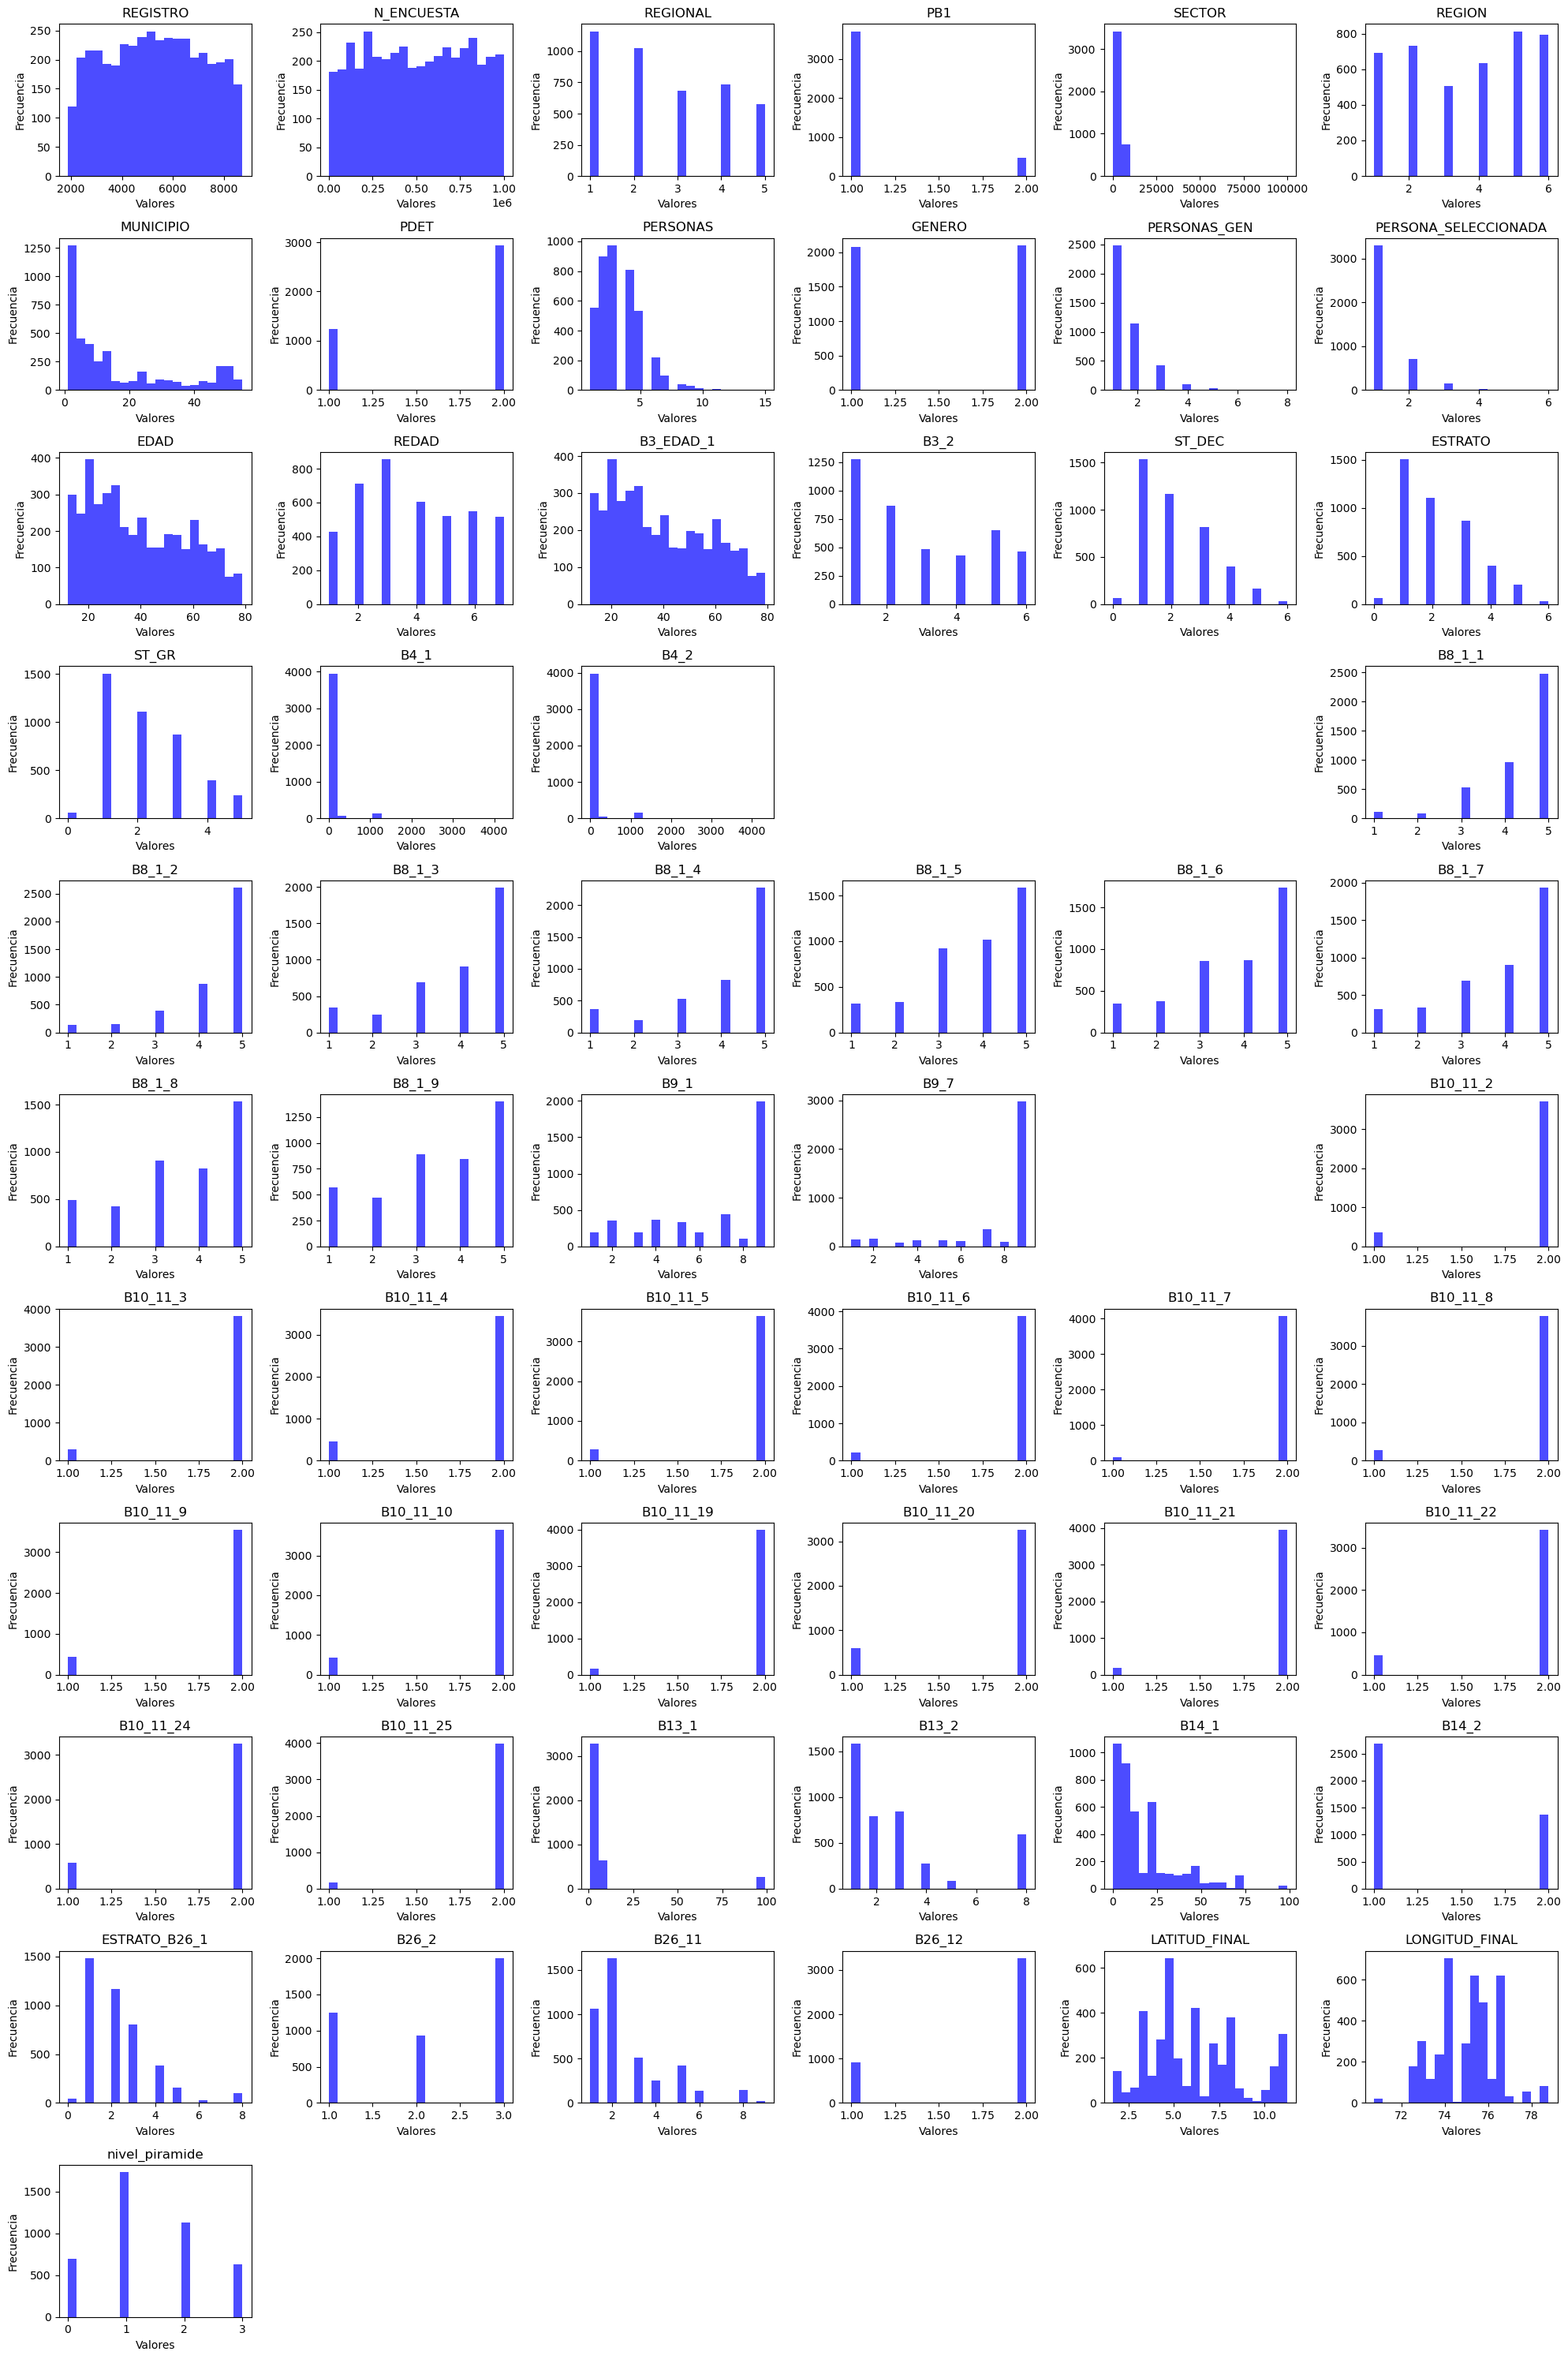

In [15]:
# Crear gráficos de distribución para las variables en el DataFrame
fig, axes = plt.subplots(nrows=11, ncols=6, figsize=(20, 30))
axes = axes.flatten()

# Generar histogramas para las 61 columnas reales
for i, col in enumerate(df.columns[:61]):  # Limitar a las 61 columnas
    if df[col].dtype in ['float64', 'int64']:  # Solo para columnas numéricas
        axes[i].hist(df[col].dropna(), bins=20, alpha=0.7, color='blue')
        axes[i].set_title(col)
        axes[i].set_ylabel('Frecuencia')
        axes[i].set_xlabel('Valores')
    else:
        axes[i].set_visible(False)  # Ocultar gráficos para columnas no numéricas

# Ocultar los gráficos adicionales vacíos si hay menos de 66 (11x6)
for j in range(len(df.columns), len(axes)):
    axes[j].set_visible(False)

# Ajustar diseño
plt.tight_layout()
plt.show()


In [16]:
# Identificar las columnas que no son numéricas
columnas_no_numericas = df.select_dtypes(exclude=['float64', 'int64']).columns
df = df.drop(columns=columnas_no_numericas)
df

,REGISTRO,N_ENCUESTA,REGIONAL,PB1,SECTOR,REGION,MUNICIPIO,PDET,PERSONAS,GENERO,...,B13_2,B14_1,B14_2,ESTRATO_B26_1,B26_2,B26_11,B26_12,LATITUD_FINAL,LONGITUD_FINAL,nivel_piramide
0,1877,764678,5,1,526,5,8,2,2,2,...,1,8,2.0,3,3,2,2,7.113764,73.136595,1
1,1885,900989,5,1,5002,5,13,2,2,2,...,3,1,2.0,2,2,5,2,7.892407,72.513830,1
2,1889,968646,5,1,5002,5,13,2,2,2,...,1,8,2.0,2,2,3,2,7.892383,72.513792,0
3,1898,180785,5,1,5006,5,13,2,6,2,...,1,6,1.0,1,3,8,2,7.899648,72.535536,0
4,1901,734690,5,1,5006,5,13,2,3,1,...,3,8,1.0,1,1,2,2,7.897977,72.535518,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,8703,294431,1,1,1,4,32,2,5,1,...,2,3,1.0,3,3,3,2,4.843900,74.066290,2
4175,8723,516103,1,1,1,4,32,2,4,1,...,3,48,1.0,2,2,2,2,4.854580,74.055531,1
4176,8726,405383,1,1,1,4,32,2,5,1,...,3,8,2.0,2,1,4,2,4.857498,74.055302,3
4177,8728,606911,1,1,2,4,32,2,3,2,...,1,3,2.0,2,1,4,2,4.854772,74.054638,1


- El DataFrame final se obtuvo tras aplicar un proceso riguroso de selección de variables relevantes y eliminar aquellas columnas con niveles de calidad de datos inferiores al 90%, conforme al criterio acordado por el equipo. Como resultado, se generó un DataFrame compuesto por 58 variables y 4,179 registros, listo para ser analizado.

- Las variables seleccionadas están estrechamente vinculadas al problema de negocio, ya que permiten perfilar de manera efectiva al universo de individuos evaluados. Es importante destacar que, para este análisis, únicamente se consideró a la persona seleccionada de cada hogar, garantizando un enfoque más representativo y pertinente.

### <div class="alert-info"> 4. Análisis exploratorio de datos

#### 4.1. Análisis univariado

In [17]:
df.describe(include = 'all')

,REGISTRO,N_ENCUESTA,REGIONAL,PB1,SECTOR,REGION,MUNICIPIO,PDET,PERSONAS,GENERO,...,B13_2,B14_1,B14_2,ESTRATO_B26_1,B26_2,B26_11,B26_12,LATITUD_FINAL,LONGITUD_FINAL,nivel_piramide
count,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,...,4179.000000,4179.000000,4045.000000,4179.000000,4179.000000,4179.000000,4179.000000,3867.000000,3867.000000,4179.000000
mean,5327.024168,504148.503709,2.649438,1.111989,2341.892558,3.606844,16.291218,1.703039,3.356784,1.502513,...,2.873893,17.124432,1.338195,2.289782,2.180905,2.655659,1.782005,6.114671,74.977072,1.401771
std,1867.926353,287045.444118,1.399705,0.315390,3669.726002,1.764975,16.906344,0.456974,1.736539,0.500054,...,2.324580,17.864908,0.473154,1.485696,0.863221,1.746740,0.412933,2.511348,1.398784,0.934477
min,1877.000000,222.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.609814,70.731204,0.000000
25%,3796.500000,251217.000000,1.000000,1.000000,16.000000,2.000000,3.000000,1.000000,2.000000,1.000000,...,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.430384,74.071317,1.000000
50%,5324.000000,503128.000000,2.000000,1.000000,812.000000,4.000000,9.000000,2.000000,3.000000,2.000000,...,2.000000,10.000000,1.000000,2.000000,2.000000,2.000000,2.000000,5.682403,75.250692,1.000000
75%,6847.500000,756356.000000,4.000000,1.000000,2563.000000,5.000000,26.000000,2.000000,4.000000,2.000000,...,3.000000,24.000000,2.000000,3.000000,3.000000,3.000000,2.000000,7.900026,75.729693,2.000000
max,8730.000000,998790.000000,5.000000,2.000000,99999.000000,6.000000,55.000000,2.000000,15.000000,2.000000,...,8.000000,99.000000,2.000000,8.000000,3.000000,9.000000,2.000000,11.269483,78.782713,3.000000


Text(0.5, 1.0, 'Faltantes de la base de datos')

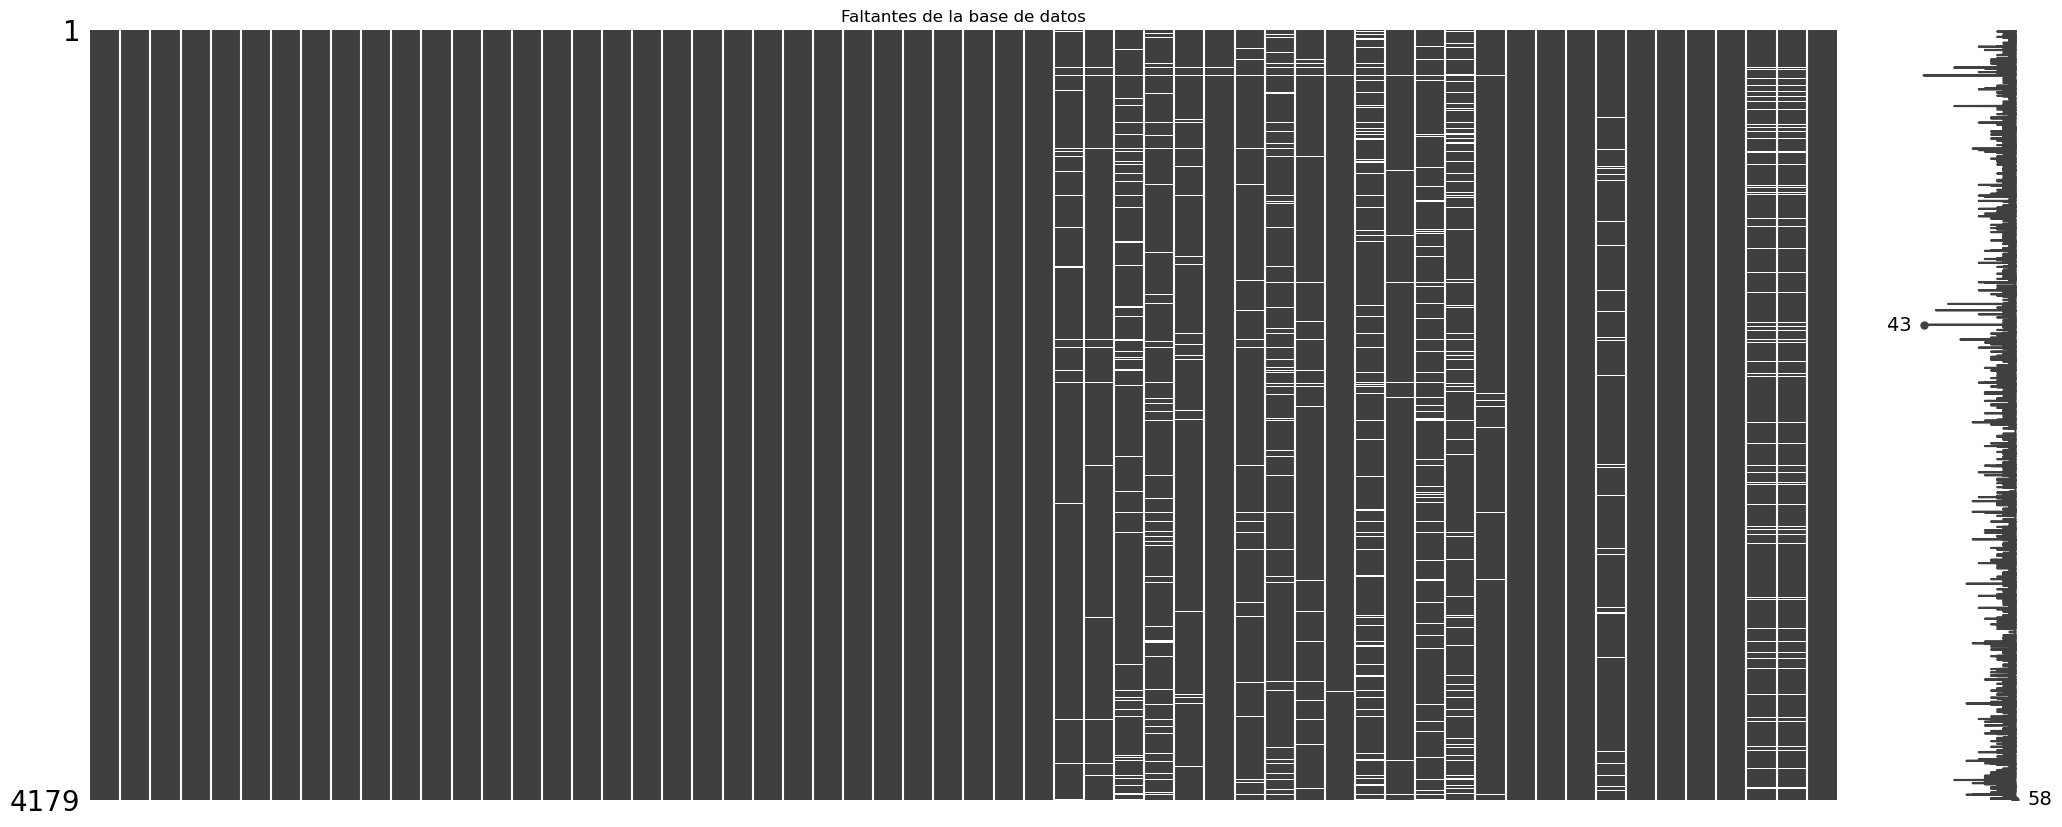

In [18]:
import missingno as msno
#Analizamos los datos faltantes de forma gráfica
msno.matrix(df)
plt.title('Faltantes de la base de datos')

In [19]:
df.columns

Index(['REGISTRO', 'N_ENCUESTA', 'REGIONAL', 'PB1', 'SECTOR', 'REGION',
       'MUNICIPIO', 'PDET', 'PERSONAS', 'GENERO', 'PERSONAS_GEN',
       'PERSONA_SELECCIONADA', 'EDAD', 'REDAD', 'B3_EDAD_1', 'B3_2', 'ST_DEC',
       'ESTRATO', 'ST_GR', 'B4_1', 'B4_2', 'B8_1_1', 'B8_1_2', 'B8_1_3',
       'B8_1_4', 'B8_1_5', 'B8_1_6', 'B8_1_7', 'B8_1_8', 'B8_1_9', 'B9_1',
       'B9_7', 'B10_11_2', 'B10_11_3', 'B10_11_4', 'B10_11_5', 'B10_11_6',
       'B10_11_7', 'B10_11_8', 'B10_11_9', 'B10_11_10', 'B10_11_19',
       'B10_11_20', 'B10_11_21', 'B10_11_22', 'B10_11_24', 'B10_11_25',
       'B13_1', 'B13_2', 'B14_1', 'B14_2', 'ESTRATO_B26_1', 'B26_2', 'B26_11',
       'B26_12', 'LATITUD_FINAL', 'LONGITUD_FINAL', 'nivel_piramide'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 58 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   REGISTRO              4179 non-null   int64  
 1   N_ENCUESTA            4179 non-null   int64  
 2   REGIONAL              4179 non-null   int64  
 3   PB1                   4179 non-null   int64  
 4   SECTOR                4179 non-null   int64  
 5   REGION                4179 non-null   int64  
 6   MUNICIPIO             4179 non-null   int64  
 7   PDET                  4179 non-null   int64  
 8   PERSONAS              4179 non-null   int64  
 9   GENERO                4179 non-null   int64  
 10  PERSONAS_GEN          4179 non-null   int64  
 11  PERSONA_SELECCIONADA  4179 non-null   int64  
 12  EDAD                  4179 non-null   int64  
 13  REDAD                 4179 non-null   int64  
 14  B3_EDAD_1             4179 non-null   int64  
 15  B3_2                 

In [21]:
def plot_dataframe(df, min_freq=0.05):
    # Separar las variables numéricas y categóricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Gráficos de variables numéricas (histogramas)
    if len(numeric_cols) > 0:
        num_rows = int(np.ceil(np.sqrt(len(numeric_cols))))
        num_cols = int(np.ceil(len(numeric_cols) / num_rows))
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
        fig.suptitle('Histogramas de Variables Numéricas', fontsize=16)
        axes = axes.flatten()
        
        for i, col in enumerate(numeric_cols):
            axes[i].hist(df[col].dropna(), bins=15, color='slategray', edgecolor='grey')
            axes[i].set_title(col, fontsize=12)
            axes[i].set_xlabel('Valor', fontsize=10)
            axes[i].set_ylabel('Frecuencia', fontsize=10)
        
        for i in range(len(numeric_cols), len(axes)):
            fig.delaxes(axes[i])  # Eliminar ejes no usados
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Gráficos de variables categóricas (gráficos de pie en una cuadrícula de 2 columnas)
    if len(categorical_cols) > 0:
        num_rows = int(np.ceil(len(categorical_cols) / 2))
        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
        fig.suptitle('Gráficos de Variables Categóricas (80% o Más)', fontsize=16)
        axes = axes.flatten()

        for i, col in enumerate(categorical_cols):
            data = df[col].value_counts(normalize=True)  # Calcular proporciones
            data = data[data >= min_freq]  # Filtrar categorías con frecuencia mínima
            data_80 = data[data.cumsum() <= 0.8]  # Filtrar categorías que sumen hasta el 80%
            if data_80.sum() < 0.8:  # Incluir categoría "Otros" si es necesario
                data_80["Otros"] = 1 - data_80.sum()
            
            # Crear gráfico de pie en el eje correspondiente
            axes[i].pie(data_80, labels=data_80.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
            axes[i].set_title(col, fontsize=12)
        
        # Eliminar ejes no usados
        for i in range(len(categorical_cols), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


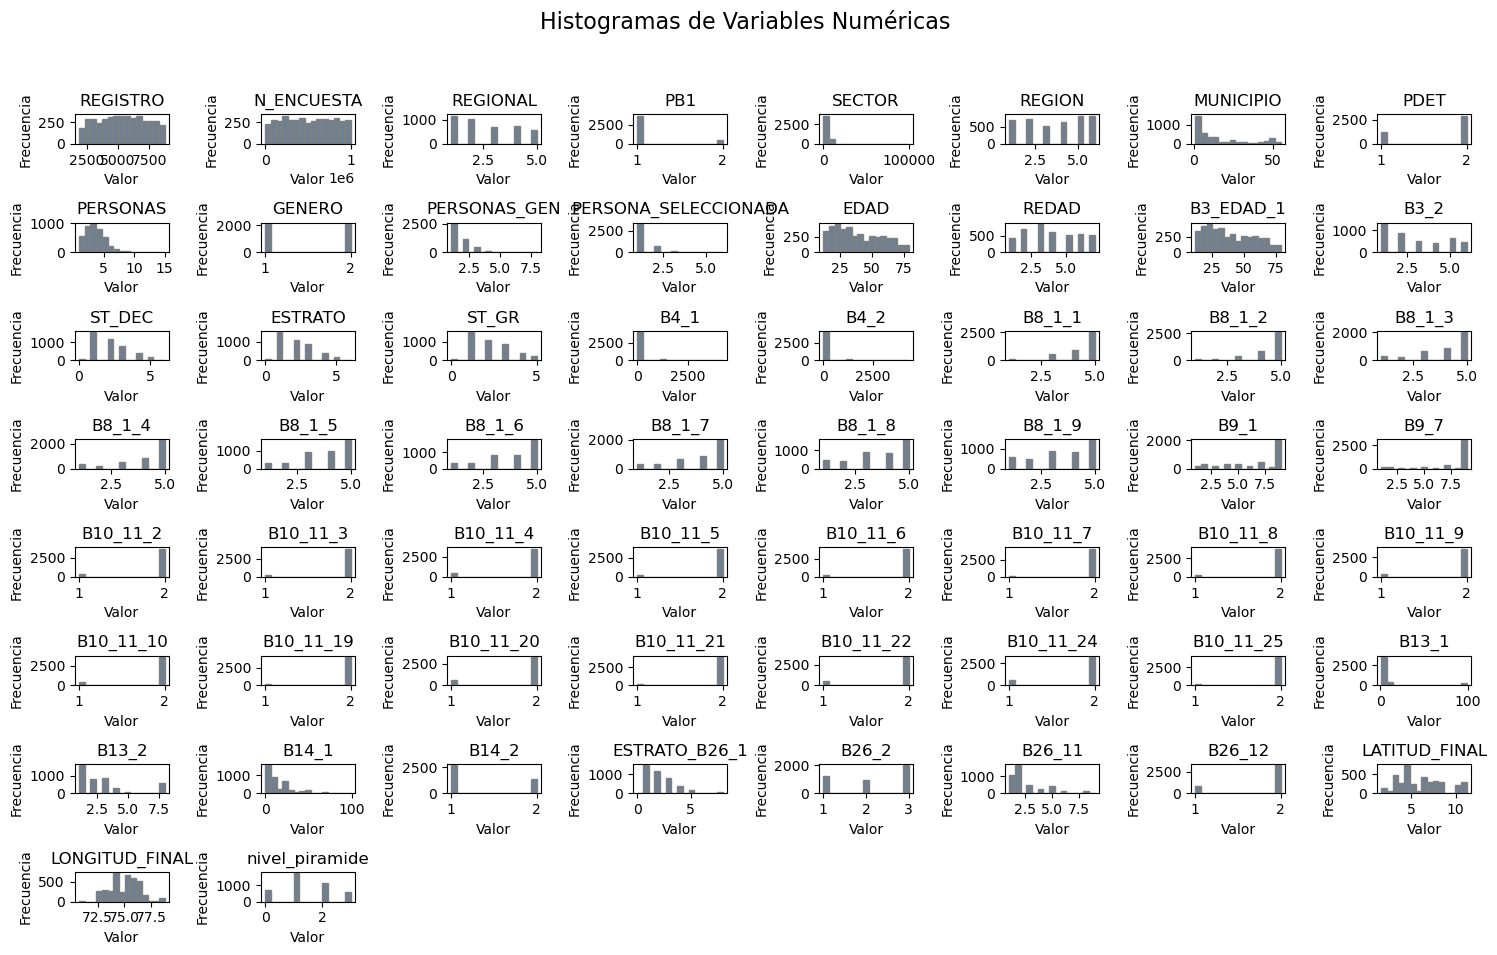

In [22]:
plot_dataframe(df)

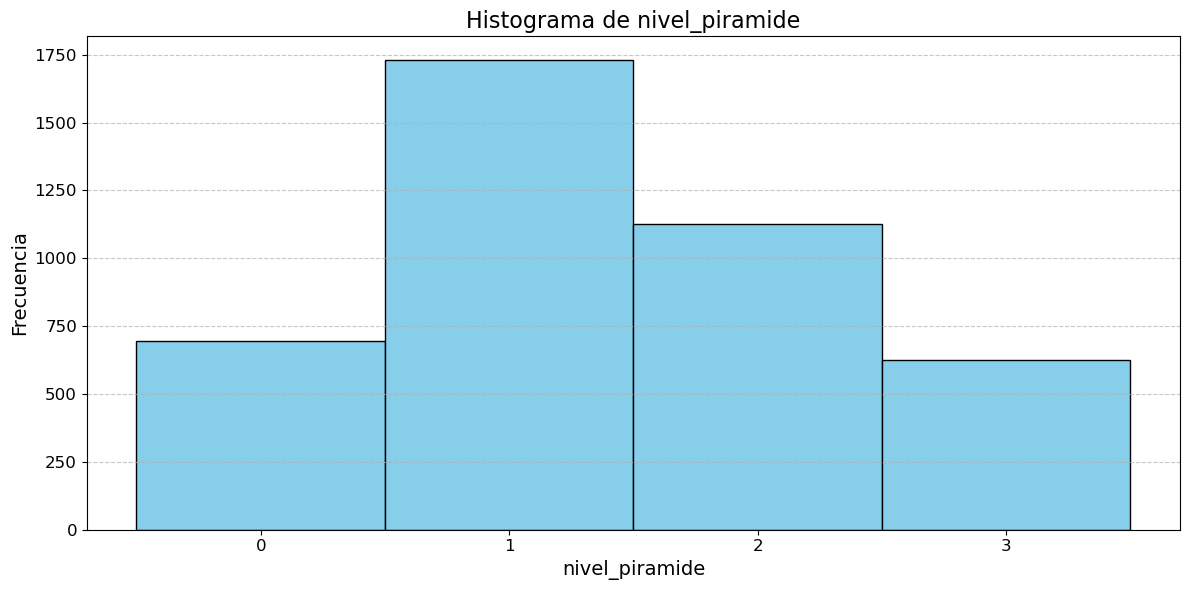

In [23]:
plt.figure(figsize=(12, 6))
plt.hist(df['nivel_piramide'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor='black', color='skyblue')
plt.title('Histograma de nivel_piramide', fontsize=16)
plt.xlabel('nivel_piramide', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks([0, 1, 2, 3], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 4.2. Análisis multivariado

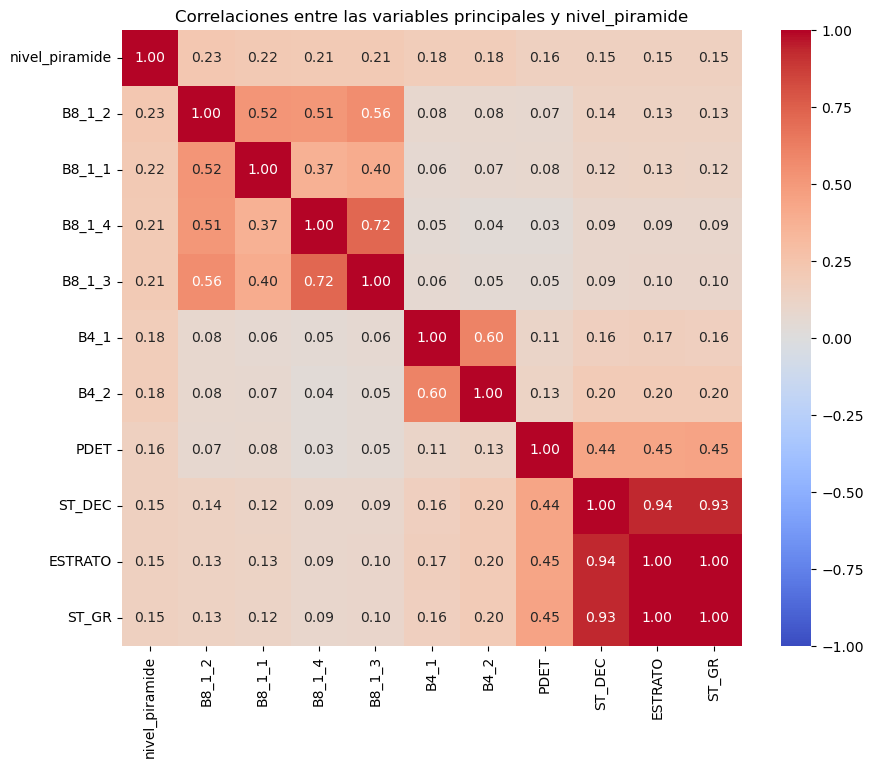

nivel_piramide    1.000000
B8_1_2            0.227874
B8_1_1            0.217377
B8_1_4            0.206178
B8_1_3            0.205433
B4_1              0.184900
B4_2              0.182173
PDET              0.155031
ST_DEC            0.152113
ESTRATO           0.151304
ST_GR             0.150775
Name: nivel_piramide, dtype: float64

In [24]:
# Calcular correlaciones entre variables numéricas y 'nivel_piramide'
correlation = df.corr()['nivel_piramide'].sort_values(ascending=False)

# Filtrar las 10 variables más correlacionadas
top_correlated = correlation.head(11).index

# Crear un heatmap de las correlaciones relevantes
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_correlated].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlaciones entre las variables principales y nivel_piramide")
plt.show()

# Mostrar las 10 variables más correlacionadas con nivel_piramide
correlation.head(11)

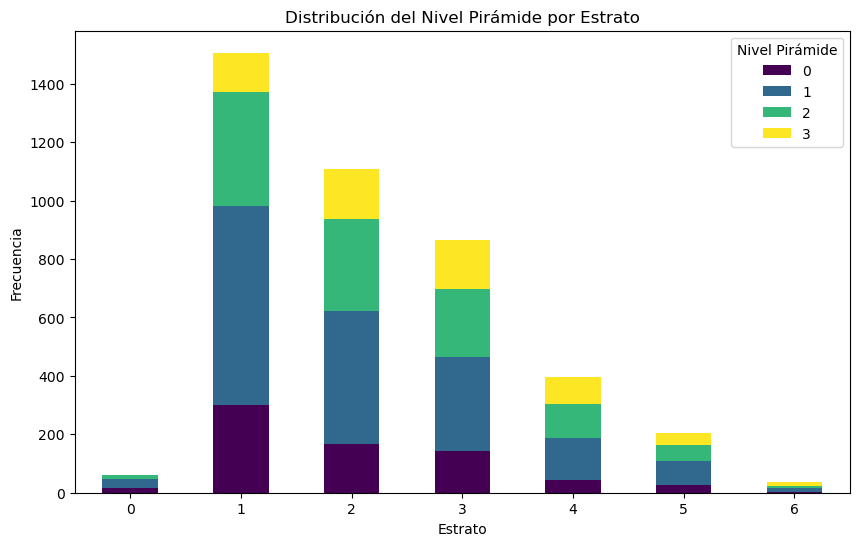

In [25]:
# Crear la tabla cruzada
crosstab = pd.crosstab(df['ESTRATO'], df['nivel_piramide'])

# Generar el gráfico de barras apiladas
crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Distribución del Nivel Pirámide por Estrato')
plt.xlabel('Estrato')
plt.ylabel('Frecuencia')
plt.legend(title='Nivel Pirámide')
plt.xticks(rotation=0)
plt.show()

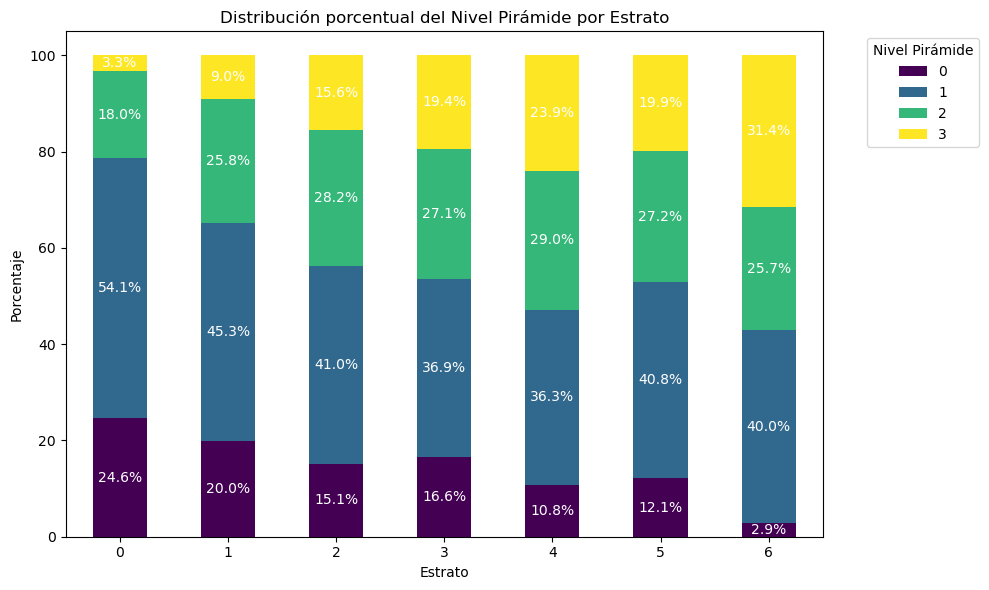

In [26]:
crosstab = pd.crosstab(df['ESTRATO'], df['nivel_piramide'], normalize='index') * 100

ax = crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

for i, row in enumerate(crosstab.values):
    cumulative = 0
    for j, value in enumerate(row):
        cumulative += value
        plt.text(i, cumulative - value / 2, f'{value:.1f}%', ha='center', va='center', color='white', fontsize=10)


plt.title('Distribución porcentual del Nivel Pirámide por Estrato')
plt.xlabel('Estrato')
plt.ylabel('Porcentaje')
plt.legend(title='Nivel Pirámide', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### <div class="alert-info"> 5. Reducción de dimensionalidad

In [27]:
X = df.loc[:, 'EDAD':'B26_12']
X.fillna(X.mode().iloc[0], inplace=True)  # Imputación por moda para MCA

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
# Aplicar Análisis de Correspondencias Múltiples (MCA)
# Paso 1: Aplicar Análisis de Correspondencias Múltiples (MCA)
# Paso 0: Limpieza de datos (df debe contener solo variables categóricas)
df = df.dropna()  # O usa df = df.fillna('Desconocido') si prefieres imputar

# Paso 1: Aplicar Análisis de Correspondencias Múltiples (MCA)
mca = prince.MCA(n_components=5, random_state=42)
mca = mca.fit(df)
X_mca = mca.transform(df)

# Paso 2: Calcular y visualizar la inercia explicada manualmente
sv = mca.singular_values_ # Valores singulares
inertia = (sv ** 2) / np.sum(sv ** 2)  # Inercia explicada por componente

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(inertia)+1), inertia, color='skyblue')
plt.xlabel('Componente MCA')
plt.ylabel('Inercia explicada')
plt.title('Inercia explicada por cada componente (MCA)')
plt.xticks(range(1, len(inertia)+1))
plt.tight_layout()
plt.show()

# Paso 3: Evaluar número óptimo de clusters con GMM
sil_scores = []
ks = range(2, 10)
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_mca)
    sil = silhouette_score(X_mca, labels)
    sil_scores.append(sil)

# Paso 4: Gráfico de Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(ks, sil_scores, marker='o', linestyle='--', color='coral')
plt.title('Silhouette Score para diferentes valores de k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Elegir el número óptimo de clusters
optimal_k = np.argmax(sil_scores) + 2
print(f"Número óptimo de clusters según Silhouette Score: {optimal_k}")

# Paso 6: Ajustar modelo GMM final
gmm_final = GaussianMixture(n_components=optimal_k, random_state=42)
clusters = gmm_final.fit_predict(X_mca)

# Paso 7: Añadir resultados al DataFrame original
df_clustered = df.copy()
df_clustered['cluster'] = clusters

# Paso 8: Visualización de clusters (usando las dos primeras componentes de MCA)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_mca[0], y=X_mca[1], hue=clusters, palette='tab10')
plt.title("Segmentación con MCA + GMM")
plt.xlabel("Componente MCA 1")
plt.ylabel("Componente MCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

AttributeError: 'MCA' object has no attribute 'singular_values_'